# Boulder 2017 Bike Share Regression Modeling

## 1. Introduction

The data exploration performed on the Boulder Trips dataset indicates weather variables have a significant impact on the number
of checkouts. This section will focus on investigating the use of various regression models on the Trips data when combined with weather variables.

In [97]:
# Import necessary libraries and functions that are needed for the analyses
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [98]:
pd.__version__

'0.22.0'

In [99]:
matplotlib.__version__

'2.1.2'

In [100]:
sns.__version__

'0.8.1'

In [101]:
sklearn.__version__

'0.19.1'

In [102]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('data/style-table.css').read() + open('data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [103]:
dF = pd.read_csv("data/Boulder_2017_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [104]:
dF.shape

(106899, 13)

In [105]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Checkout_WeekDay,Checkout_Month
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,0,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,6,1


In [106]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)

In [107]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106899 entries, 0 to 106898
Data columns (total 4 columns):
Checkout_Date       106899 non-null object
Checkout_Hour       106899 non-null int64
Checkout_WeekDay    106899 non-null int64
Checkout_Month      106899 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.3+ MB


In [108]:
dF['Checkout_Date'] = pd.to_datetime(dF['Checkout_Date'])

### Re-arrange columns to set up target class

In [109]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [110]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106899 entries, 0 to 106898
Data columns (total 4 columns):
Checkout_Date       106899 non-null datetime64[ns]
Checkout_Month      106899 non-null int64
Checkout_WeekDay    106899 non-null int64
Checkout_Hour       106899 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.3 MB


In [111]:
dW = pd.read_csv("data/Boulder_2017_Hourly_Weather_Forecast.csv")

In [112]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
Date                   8760 non-null object
Hour                   8760 non-null int64
apparentTemperature    8760 non-null float64
cloudCover             8760 non-null float64
humidity               8760 non-null float64
temperature            8760 non-null float64
visibility             8760 non-null float64
windSpeed              8760 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 547.6+ KB


In [113]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [114]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [115]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [116]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [117]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [118]:
dFW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265 entries, 0 to 7264
Data columns (total 5 columns):
Checkout_Date          7265 non-null datetime64[ns]
Checkout_Month         7265 non-null int64
Checkout_WeekDay       7265 non-null int64
Checkout_Hour          7265 non-null int64
Number_Of_Checkouts    7265 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 283.9 KB


In [119]:
dFW['Number_Of_Checkouts'].sum()

106899

In [120]:
dFW.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Number_Of_Checkouts
0,2017-01-01,1,6,0,6
1,2017-01-01,1,6,1,2
2,2017-01-01,1,6,2,1
3,2017-01-01,1,6,3,1
4,2017-01-01,1,6,7,3


In [121]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
Date                   8760 non-null datetime64[ns]
Checkout_Hour          8760 non-null int64
apparentTemperature    8760 non-null float64
cloudCover             8760 non-null float64
humidity               8760 non-null float64
temperature            8760 non-null float64
visibility             8760 non-null float64
windSpeed              8760 non-null float64
Checkout_WeekDay       8760 non-null int64
Checkout_Month         8760 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 684.5 KB


In [122]:
dW.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay,Checkout_Month
0,2017-01-01,0,13.05,0.31,0.69,20.52,10.0,5.51,6,1
1,2017-01-01,1,14.71,0.31,0.69,20.42,10.0,3.99,6,1
2,2017-01-01,2,15.64,0.31,0.63,21.00,10.0,3.80,6,1
3,2017-01-01,3,14.38,0.31,0.68,21.86,10.0,5.77,6,1
4,2017-01-01,4,21.45,0.31,0.59,27.26,10.0,5.06,6,1


In [123]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [124]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 14 columns):
Date                   8760 non-null datetime64[ns]
Checkout_Hour          8760 non-null int64
apparentTemperature    8760 non-null float64
cloudCover             8760 non-null float64
humidity               8760 non-null float64
temperature            8760 non-null float64
visibility             8760 non-null float64
windSpeed              8760 non-null float64
Checkout_WeekDay_x     8760 non-null int64
Checkout_Month_x       8760 non-null int64
Checkout_Date          7264 non-null datetime64[ns]
Checkout_Month_y       7264 non-null float64
Checkout_WeekDay_y     7264 non-null float64
Number_Of_Checkouts    7264 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(3)
memory usage: 1.0 MB


In [125]:
dT.tail()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
8755,2017-12-31,19,7.51,0.31,0.79,14.08,8.56,3.91,6,12,NaT,NaN,NaN,NaN
8756,2017-12-31,20,7.34,0.23,0.82,13.14,8.33,3.35,6,12,2017-12-31,12.0,6.0,1.0
8757,2017-12-31,21,6.57,0.23,0.83,12.72,8.29,3.52,6,12,NaT,NaN,NaN,NaN
8758,2017-12-31,22,12.50,0.15,0.81,12.50,7.68,2.83,6,12,2017-12-31,12.0,6.0,1.0
8759,2017-12-31,23,12.47,0.49,0.81,12.47,7.79,2.32,6,12,NaT,NaN,NaN,NaN


In [126]:
dT['Number_Of_Checkouts'].sum()

106896.0

In [127]:
dT.isnull().values.any()

True

In [128]:
nan_rows = dT[dT.isnull().T.any().T]

In [129]:
dT = dT.drop(dT.index[nan_rows.index])

In [130]:
dT.isnull().values.any()

False

In [131]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7264 entries, 0 to 8758
Data columns (total 14 columns):
Date                   7264 non-null datetime64[ns]
Checkout_Hour          7264 non-null int64
apparentTemperature    7264 non-null float64
cloudCover             7264 non-null float64
humidity               7264 non-null float64
temperature            7264 non-null float64
visibility             7264 non-null float64
windSpeed              7264 non-null float64
Checkout_WeekDay_x     7264 non-null int64
Checkout_Month_x       7264 non-null int64
Checkout_Date          7264 non-null datetime64[ns]
Checkout_Month_y       7264 non-null float64
Checkout_WeekDay_y     7264 non-null float64
Number_Of_Checkouts    7264 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(3)
memory usage: 851.2 KB


In [132]:
dT.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
0,2017-01-01,0,13.05,0.31,0.69,20.52,10.0,5.51,6,1,2017-01-01,1.0,6.0,6.0
1,2017-01-01,1,14.71,0.31,0.69,20.42,10.0,3.99,6,1,2017-01-01,1.0,6.0,2.0
2,2017-01-01,2,15.64,0.31,0.63,21.00,10.0,3.80,6,1,2017-01-01,1.0,6.0,1.0
3,2017-01-01,3,14.38,0.31,0.68,21.86,10.0,5.77,6,1,2017-01-01,1.0,6.0,1.0
7,2017-01-01,7,36.02,0.31,0.36,38.12,10.0,3.18,6,1,2017-01-01,1.0,6.0,3.0


In [133]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [134]:
# Convert Checkout_Hour to integer type
dT['Number_Of_Checkouts'] = dT['Number_Of_Checkouts'].astype(int)

In [135]:
dT.head(1)

,Checkout_Hour,Apparent_Temperature,Cloud_Cover,Humidity,Temperature,Visibility,Wind_Speed,Checkout_WeekDay,Checkout_Month,Checkout_Date,Number_Of_Checkouts
0,0,13.05,0.31,0.69,20.52,10.0,5.51,6,1,2017-01-01,6


In [136]:
data = dT.copy(deep=True)

In [137]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [138]:
data = data[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

In [139]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts
0,2017-01-01,1,6,0,20.52,13.05,0.31,0.69,5.51,10.0,6
1,2017-01-01,1,6,1,20.42,14.71,0.31,0.69,3.99,10.0,2
2,2017-01-01,1,6,2,21.00,15.64,0.31,0.63,3.80,10.0,1
3,2017-01-01,1,6,3,21.86,14.38,0.31,0.68,5.77,10.0,1
7,2017-01-01,1,6,7,38.12,36.02,0.31,0.36,3.18,10.0,3


### Convert the numeric Calendar and Clock columns into categorical columns

In [140]:
month_dummies = pd.get_dummies(data.Checkout_Month, prefix='month')

In [141]:
weekday_dummies = pd.get_dummies(data.Checkout_WeekDay, prefix='weekday')

In [142]:
hour_dummies = pd.get_dummies(data.Checkout_Hour, prefix='hour')

In [143]:
data = pd.concat([data, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [144]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2017-01-01,1,6,0,20.52,13.05,0.31,0.69,5.51,10.0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,1,6,1,20.42,14.71,0.31,0.69,3.99,10.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-01,1,6,2,21.00,15.64,0.31,0.63,3.80,10.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-01,1,6,3,21.86,14.38,0.31,0.68,5.77,10.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017-01-01,1,6,7,38.12,36.02,0.31,0.36,3.18,10.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Keep 20 samples aside for use in prediction on unseen samples

In [145]:
dUT = data.sample(n=20, random_state=123)

In [146]:
del_rows = dUT.index

In [147]:
data.drop(del_rows, axis=0, inplace=True)

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7244 entries, 0 to 8758
Data columns (total 54 columns):
Checkout_Date           7244 non-null datetime64[ns]
Checkout_Month          7244 non-null int64
Checkout_WeekDay        7244 non-null int64
Checkout_Hour           7244 non-null int64
Temperature             7244 non-null float64
Apparent_Temperature    7244 non-null float64
Cloud_Cover             7244 non-null float64
Humidity                7244 non-null float64
Wind_Speed              7244 non-null float64
Visibility              7244 non-null float64
Number_Of_Checkouts     7244 non-null int32
month_1                 7244 non-null uint8
month_2                 7244 non-null uint8
month_3                 7244 non-null uint8
month_4                 7244 non-null uint8
month_5                 7244 non-null uint8
month_6                 7244 non-null uint8
month_7                 7244 non-null uint8
month_8                 7244 non-null uint8
month_9                 7244 non-nul

In [149]:
data = data[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [150]:
data.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,20.52,13.05,0.31,5.51,0.69,10.0,6
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,1,20.42,14.71,0.31,3.99,0.69,10.0,2
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,2,21.00,15.64,0.31,3.80,0.63,10.0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,3,21.86,14.38,0.31,5.77,0.68,10.0,1
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,8,36.91,31.77,0.31,6.44,0.33,10.0,10


In [151]:
array = data.values

In [152]:
X = array[:,0:47]
X[0]

array([ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  1.  ,  6.  ,  0.  , 20.52, 13.05,  0.31,  5.51,
        0.69, 10.  ])

In [153]:
y = array[:,47]
y[0]

6.0

## Feature Correlations

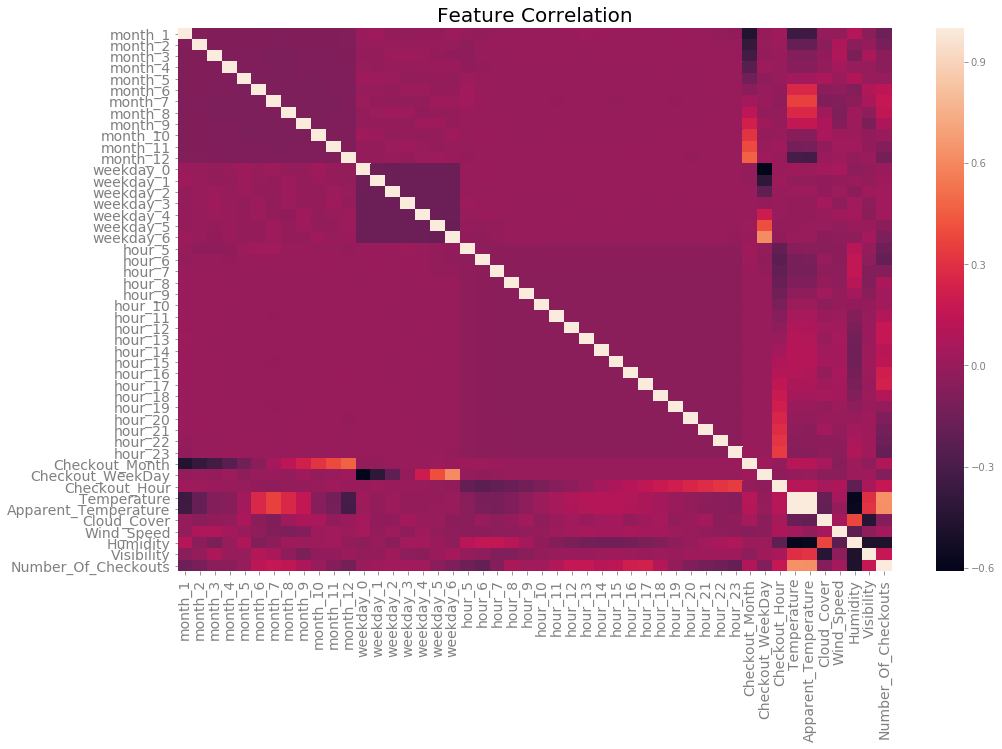

In [154]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlation", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [155]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 2. Modeling - All Features

### Plot Feature Importance

In [156]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
IPython_default = plt.rcParams.copy()
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [157]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=12)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=18)
    plt.show()

### Get Regression Metrics

In [158]:
def get_regression_metrics(model, actual, predicted):
    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)**0.5,
                          'RMSE' : metrics.mean_squared_error(actual, predicted)}
    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

### Linear Regression

In [159]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.intercept_: {}".format(lr.intercept_))
print("lr.coef_: {}".format(lr.coef_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.intercept_: -483996403098.4032
lr.coef_: [-2.55322575e+07 -2.55322578e+07 -2.55322563e+07 -2.55322558e+07
 -2.55322553e+07 -2.55322532e+07 -2.55322534e+07 -2.55322528e+07
 -2.55322534e+07 -2.55322534e+07 -2.55322563e+07 -2.55322568e+07
  4.84021935e+11  4.84021935e+11  4.84021935e+11  4.84021935e+11
  4.84021935e+11  4.84021935e+11  4.84021935e+11 -7.95421338e-01
  1.99610195e+00  9.71411072e+00  1.69444335e+01  1.42902043e+01
  1.25673224e+01  1.56474032e+01  1.88676355e+01  1.84872680e+01
  1.52117665e+01  1.71281048e+01  2.09656300e+01  2.24026547e+01
  1.58787762e+01  1.04599902e+01  6.39400203e+00  4.61022034e+00
  3.06158704e+00  1.44009421e+00  5.90190601e-01 -2.90894897e-01
 -2.51012076e+00 -2.59796496e-01 -1.96142914e+00  6.34552151e-01]

Training Set Score: 0.703
Testing Set Score: 0.698


,Linear Regression
R Squared,0.835194
RMSE,49.045569


### Lasso Regression

In [160]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.01)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("lso.intercept_: {}".format(lso.intercept_))
print("lso.coef_: {}".format(lso.coef_))
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

lso.intercept_: -17.550000388634835
lso.coef_: [-0.53392065 -1.27151561 -0.25363777 -0.          0.          1.49016906
  0.82759315  1.6813785   1.37984125  2.24172599 -0.05360136 -0.05062953
 -0.62963434  0.09549201 -0.          0.2726925   0.99660341 -1.56233027
 -3.54378759 -1.72059432  0.3294943   8.01721038 15.10121212 12.27794329
 10.51265663 13.41883773 16.51699109 16.13424685 12.78565495 14.6724996
 18.60675013 20.12166104 13.63401268  8.38155057  4.38166954  2.68174888
  1.2077144  -0.          0.68553351 -0.32302458 -1.60623255 -0.27256803
 -0.76261394  0.58583842]
Training Set Score: 0.700
Testing Set Score: 0.696


C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Lasso Regression
R Squared,0.834024
RMSE,49.362246


### Ridge Regression

In [161]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.01)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("rge.intercept_: {}".format(rge.intercept_))
print("rge.coef_: {}".format(rge.coef_))
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

rge.intercept_: -17.550000388634835
rge.coef_: [-0.53392065 -1.27151561 -0.25363777 -0.          0.          1.49016906
  0.82759315  1.6813785   1.37984125  2.24172599 -0.05360136 -0.05062953
 -0.62963434  0.09549201 -0.          0.2726925   0.99660341 -1.56233027
 -3.54378759 -1.72059432  0.3294943   8.01721038 15.10121212 12.27794329
 10.51265663 13.41883773 16.51699109 16.13424685 12.78565495 14.6724996
 18.60675013 20.12166104 13.63401268  8.38155057  4.38166954  2.68174888
  1.2077144  -0.          0.68553351 -0.32302458 -1.60623255 -0.27256803
 -0.76261394  0.58583842]
Training Set Score: 0.700
Testing Set Score: 0.696


C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Ridge Regression
R Squared,0.834024
RMSE,49.362246


### Bayesian Ridge Regression

In [162]:
# Bayesian Ridge Regressor
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("brr.intercept_: {:.3f}".format(brr.intercept_))
print("brr.coef_: {}".format(brr.coef_))
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

brr.intercept_: -15.905
brr.coef_: [-2.24064087 -2.54674918 -1.1170053  -0.6205868  -0.13394567  1.92744749
  1.644448    2.2698241   1.67775001  1.78722345 -1.05660029 -1.59116495
 -0.08411144  0.69901256  0.6222423   0.99530041  1.69711514 -0.9808406
 -2.94871838 -1.0113353   1.76311943  9.45726323 16.65274161 13.982583
 12.25518532 15.31074269 18.50857285 18.12621582 14.85116474 16.75831624
 20.59826092 22.04259566 15.53534777 10.14908499  6.10360862  4.33312939
  2.80086012  1.18880993  0.59804204 -0.29413381 -2.39845072 -0.26060292
 -2.00441598  0.62297059]
Training Set Score: 0.702
Testing Set Score: 0.698


,Bayesion Ridge Regression
R Squared,0.835202
RMSE,49.043449


### Decision Tree Regression

In [163]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.500


,Decision Tree Regression
R Squared,0.706809
RMSE,81.148574


### Random Forest Regression

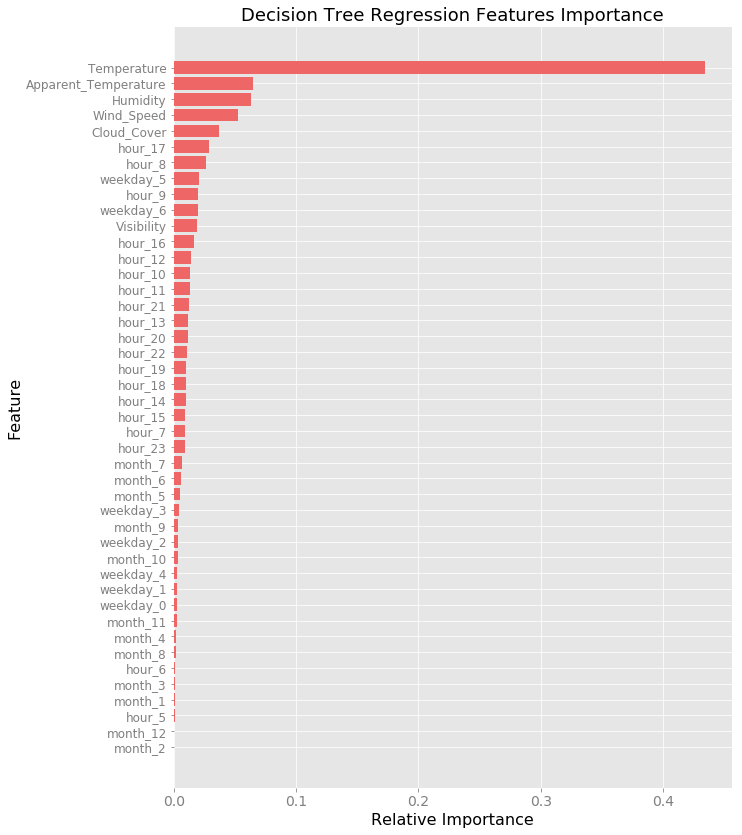

In [164]:
plot_feature_importances(dtr, 'Decision Tree Regression')

In [165]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.948
Testing Set Score: 0.729


,Random Forest Regression
R Squared,0.854094
RMSE,43.868339


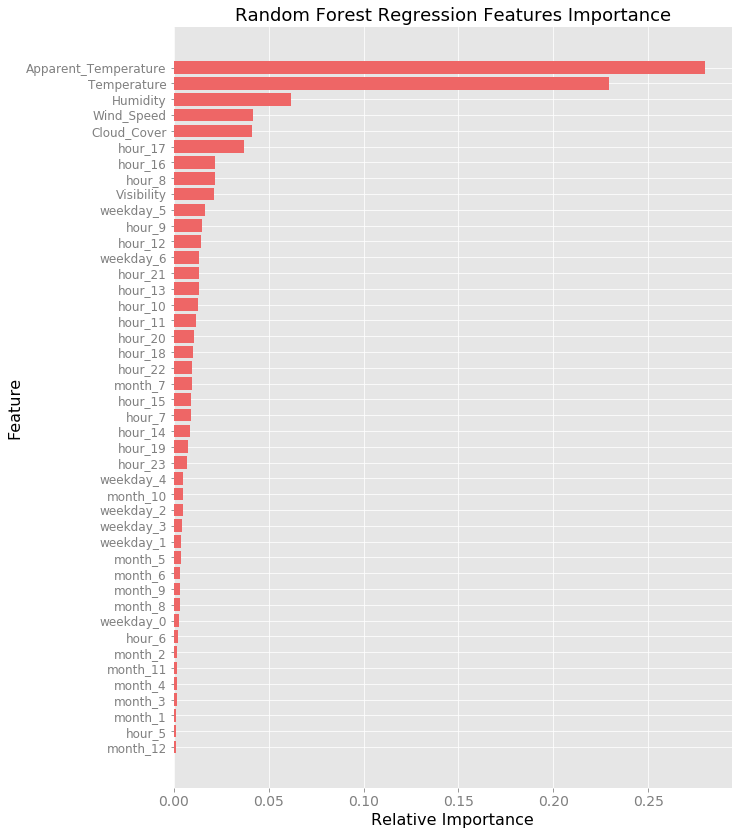

In [166]:
plot_feature_importances(rfr, 'Random Forest Regression')

#### Extra Trees Regression

In [167]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.735


,Extra Trees Regression
R Squared,0.857548
RMSE,42.909462


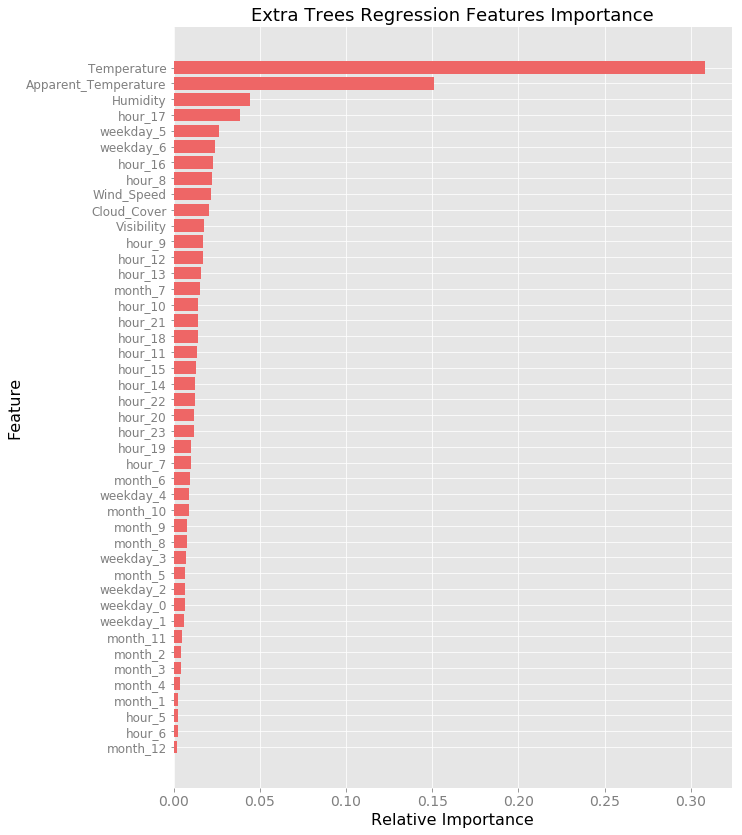

In [168]:
plot_feature_importances(etr, 'Extra Trees Regression')

#### Nearest Neighbors Regression

In [169]:
# Nearest Neighbors Regressor
knr = KNeighborsRegressor(n_neighbors=10)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.586
Testing Set Score: 0.499


,Nearest Neighbors Regression
R Squared,0.706237
RMSE,81.279623


## Regression Summary - Categorical Feature Set

In [170]:
# Regression Summary
print("Regression Summary - Categorical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics,
                                dtr_metrics, rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary - Categorical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.835194,0.834024,0.834024,0.835202,0.706809,0.854094,0.857548,0.706237
RMSE,49.045569,49.362246,49.362246,49.043449,81.148574,43.868339,42.909462,81.279623


## Summary

The Extra Trees model attains the highest accuracy with the lowest RMSE.

## 3. Modeling - Selected Features

In [171]:
data = dT.copy(deep=True)

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7264 entries, 0 to 8758
Data columns (total 11 columns):
Checkout_Hour           7264 non-null int64
Apparent_Temperature    7264 non-null float64
Cloud_Cover             7264 non-null float64
Humidity                7264 non-null float64
Temperature             7264 non-null float64
Visibility              7264 non-null float64
Wind_Speed              7264 non-null float64
Checkout_WeekDay        7264 non-null int64
Checkout_Month          7264 non-null int64
Checkout_Date           7264 non-null datetime64[ns]
Number_Of_Checkouts     7264 non-null int32
dtypes: datetime64[ns](1), float64(6), int32(1), int64(3)
memory usage: 652.6 KB


In [173]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

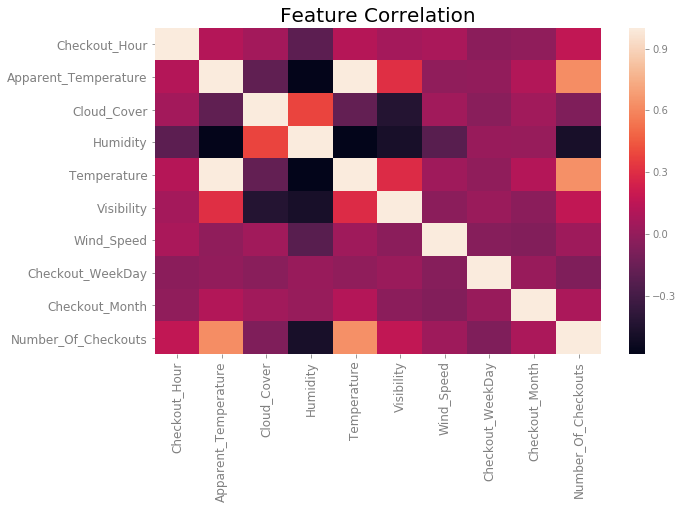

In [174]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
            'Number_Of_Checkouts']
plt.figure(figsize=(10,6))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlation", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [175]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]

In [176]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [177]:
array = data.values
X = array[:,0:9]
X[0]

array([ 1.  ,  6.  ,  0.  , 20.52, 13.05,  0.31,  5.51,  0.69, 10.  ])

In [178]:
y = array[:,9]
y[0]

6.0

In [179]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Linear Regression

In [180]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.coef_: [  0.09200085  -0.4086664    0.08930188   0.71082857  -0.29168264
   5.24522264  -0.23343236 -12.9939403   -0.58536367]
lr.intercept_: 4.000206359831342

Training Set Score: 0.443
Testing Set Score: 0.448


,Linear Regression
R Squared,0.669047
RMSE,91.424670


### Lasso Regression

In [181]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.1)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

Training Set Score: 0.436
Testing Set Score: 0.441


,Lasso Regression
R Squared,0.664195
RMSE,92.495261


### Ridge Regression

In [182]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.1)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

Training Set Score: 0.436
Testing Set Score: 0.441


,Ridge Regression
R Squared,0.664195
RMSE,92.495261


### Bayesian Ridge Regression

In [183]:
# Bayesian Ridge Regression
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

Training Set Score: 0.443
Testing Set Score: 0.448


,Bayesion Ridge Regression
R Squared,0.669024
RMSE,91.429825


### Decision Tree Regression

In [184]:
# Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.590


,Decision Tree Regression
R Squared,0.767846
RMSE,67.927982


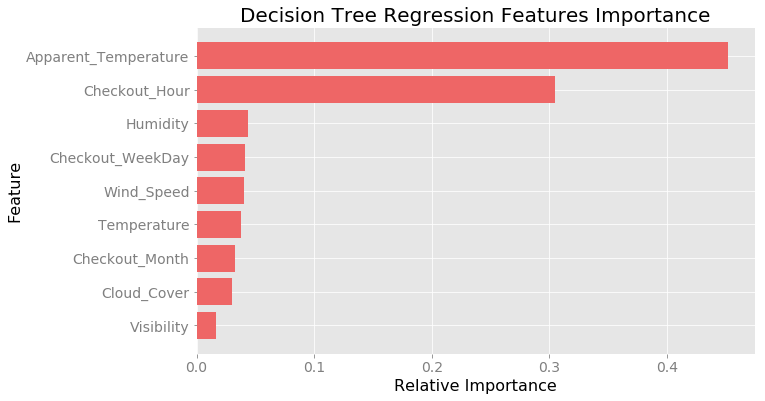

In [185]:
plot_feature_importances(dtr, 'Decision Tree Regression')


### Random Forest Regression

In [186]:
# Random Forest Regression
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.955
Testing Set Score: 0.753


,Random Forest Regression
R Squared,0.867894
RMSE,40.841739


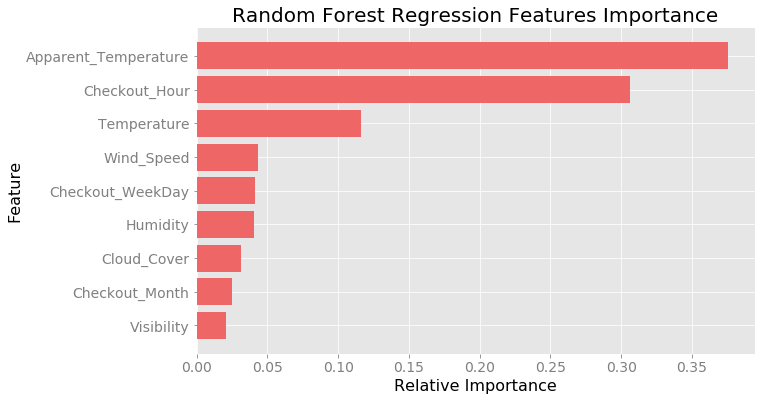

In [187]:
plot_feature_importances(rfr, 'Random Forest Regression')

### Extra Trees Regression

In [188]:
# Extra Trees Regression
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.763


,Extra Trees Regression
R Squared,0.873499
RMSE,39.226266


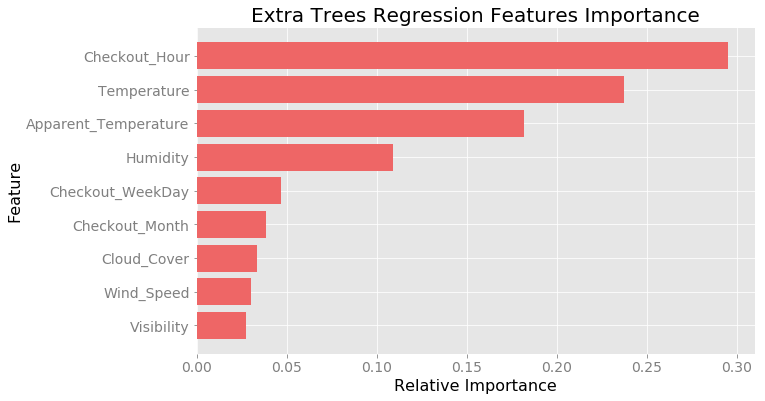

In [189]:
plot_feature_importances(etr, 'Extra Trees Regression')

### Nearest Neighbors Regression

In [190]:
# Nearest Neighbors Regression
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.884
Testing Set Score: 0.656


,Nearest Neighbors Regression
R Squared,0.809650
RMSE,57.013188


## Regression Summary with Numerical Feature Set

In [191]:
# Regression Summary
print("Regression Summary With Numericical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics, dtr_metrics,
                                rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary With Numericical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.669047,0.664195,0.664195,0.669024,0.767846,0.867894,0.873499,0.809650
RMSE,91.424670,92.495261,92.495261,91.429825,67.927982,40.841739,39.226266,57.013188


## Test Extra Trees Regressor on Unseen Samples

In [192]:
dUT = dUT[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
                 'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
pred_X = dUT[features]
act_y = dUT['Number_Of_Checkouts']
pred_array = dUT.values
pred_X_array = pred_array[:,0:9]
act_y_array = pred_array[:,9]
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X, y)
pred = etr.predict(pred_X_array)
print('pred =', pred)
print('act = ', act_y_array)

pred = [33.  1. 45.  6. 30. 26. 30.  2. 12.  3. 29. 27. 26.  1. 18. 50. 12.  3.
 15.  2.]
act =  [33.  1. 45.  6. 30. 26. 30.  2. 12.  3. 29. 27. 26.  1. 18. 50. 12.  3.
 15.  2.]


## 4. Summary

With reduced features, the Extra Trees model attains the highest accuracy with the lowest RMSE. The linear models have almost four times higher RMSE values as compared to the Extra Trees model. This suggests that the prediction can be improved even with reduced features.